In [1]:
import torch 
from torch import nn
import json

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights 

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import trange
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

In [2]:
import gc
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
# call this when you hit OOM

In [3]:
print(torch.__version__)

2.5.1+cu121


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
from pathlib import Path

data_root = Path("food-101")
print(data_root.exists())
print((data_root / "images").exists())
print((data_root / "meta").exists())

True
True
True


In [6]:
from food101_dataset import idx_food101, Food101Dataset, load_json
samples, class_to_idx = idx_food101("food-101")

data = Food101Dataset(samples, class_to_idx)
print(len(data))

img, label = data[10001]
print(type(img), label)

101000
<class 'PIL.Image.Image'> 10


In [7]:
samples, class_to_idx = idx_food101("food-101")
print(len(class_to_idx))
print(list(class_to_idx.keys())[:10])

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [71]:
# from sklearn.model_selection import train_test_split

# samples, class_to_idx = idx_food101("food-101")
# labels = [label for _, label in samples]

# train_set, temp_set = train_test_split(
#     samples,
#     test_size=0.2,
#     stratify=labels,
#     random_state=78
# )

# temp_set_labels = [label for _, label in temp_set]

# val_set, test_set = train_test_split(
#     temp_set,
#     test_size = 0.5,
#     stratify=temp_set_labels,
#     random_state=78
# )

In [72]:
# output_dir = Path("data")
# output_dir.mkdir(parents=True, exist_ok=True)

# json.dump(train_set, open("data/train.json", "w"))  
# json.dump(val_set, open("data/val.json", "w"))
# json.dump(test_set, open("data/test.json", "w"))
# json.dump(class_to_idx, open("data/class_to_idx.json", "w"))

In [8]:
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
     
])

In [9]:
train_samples = load_json("data/train.json")
val_samples = load_json("data/val.json")
test_samples = load_json("data/test.json")
class_to_idx = load_json("data/class_to_idx.json")

train_ds = Food101Dataset(train_samples, class_to_idx, transform=train_tf)
test_ds = Food101Dataset(test_samples, class_to_idx, transform=val_tf)
val_ds = Food101Dataset(val_samples, class_to_idx, transform=val_tf)

In [10]:
print(f"Train set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")
print(f"Class mapping saved for {len(class_to_idx)} classes")

Train set: 80800 samples
Validation set: 10100 samples
Test set: 10100 samples
Class mapping saved for 101 classes


In [76]:
# CALCULATING THE MEAN AND STD OF THE DATASET ITSELF


# tmp_tf = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor()
# ])

# train_tmp = Food101Dataset(train_samples, class_to_idx, transform=tmp_tf)

# tr_dl = DataLoader(train_tmp, batch_size = 64, shuffle = False, num_workers=4)

# mean = torch.zeros(3)
# std = torch.zeros(3)
# n_pixels = 0

# for imgs, _ in tr_dl:
#     b,c,h,w = imgs.shape
#     pixels = b*h*w

#     mean += imgs.sum(dim = [0,2,3])
#     std += (imgs**2).sum(dim = [0,2,3])
#     n_pixels += pixels

# mean = mean / n_pixels
# std = (std / n_pixels - mean**2).sqrt()

# print(f"Mean: {mean}")
# print(f"Standard deviation: {std}")

In [11]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers = 4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers = 0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers = 2, pin_memory=True)

In [12]:
images, labels = next(iter(train_loader))

print(images.shape)
print(images.dtype)
print(labels.shape)
print(labels.dtype)

torch.Size([32, 3, 224, 224])
torch.float32
torch.Size([32])
torch.int64


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

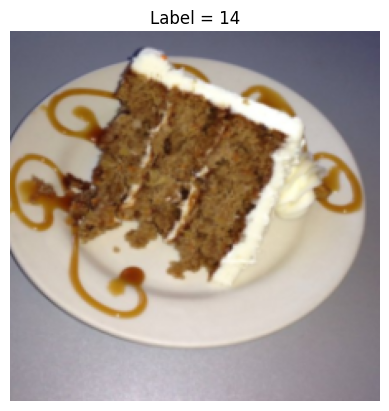

In [79]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

img = images[5]
img = img * std + mean
img = img.clamp(0,1)
img = img.permute(1,2,0)

plt.imshow(img)
plt.title(f"Label = {labels[5].item()}")
plt.axis("off")

In [13]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights = weights)

In [14]:
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [15]:
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

In [16]:
model = model.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.fc.parameters(),
    lr = 1e-3,
    weight_decay=1e-4
)

In [17]:
def train_one_epoch(model, dt_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(dt_loader, desc='Train', leave = True)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = out.argmax(dim = 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss = loss.item())
    return total_loss / total, correct / total

In [18]:
def validation_loop(model, dt_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dt_loader:
            images = images.to(device)
            labels = labels.to(device)

            outs = model(images)
            loss = criterion(outs, labels)

            total_loss += loss.item() * images.size(0)
            preds = outs.argmax(dim = 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

In [29]:
best_val_acc = 0.0
patience = 3
patience_counter = 0

EPOCHS = 15
min_delta = 1e-3

for epoch in trange(EPOCHS, desc='Epochs'):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    val_loss, val_acc = validation_loop(model, val_loader, criterion, device)
    
    print(
        f'Epoch {epoch+1} |'
        f'Train accuracy: {train_acc:.4f} |'
        f'Val accuracy: {val_acc:.4f} |'
        )
    
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered") 
        break

Epochs:   7%|▋         | 1/15 [19:55<4:38:54, 1195.31s/it]

Epoch 1 |Train accuracy: 0.3977 |Val accuracy: 0.5455 |


Epochs:  13%|█▎        | 2/15 [26:46<2:39:01, 733.93s/it] 

Epoch 2 |Train accuracy: 0.5047 |Val accuracy: 0.5771 |


Epochs:  20%|██        | 3/15 [33:22<1:55:56, 579.67s/it]

Epoch 3 |Train accuracy: 0.5322 |Val accuracy: 0.5801 |


Epochs:  27%|██▋       | 4/15 [39:58<1:32:58, 507.15s/it]

Epoch 4 |Train accuracy: 0.5494 |Val accuracy: 0.6007 |


Epochs:  33%|███▎      | 5/15 [46:49<1:18:45, 472.53s/it]

Epoch 5 |Train accuracy: 0.5587 |Val accuracy: 0.6020 |


Epochs:  40%|████      | 6/15 [53:34<1:07:26, 449.56s/it]

Epoch 6 |Train accuracy: 0.5658 |Val accuracy: 0.5964 |


Epochs:  47%|████▋     | 7/15 [1:00:05<57:22, 430.34s/it]

Epoch 7 |Train accuracy: 0.5703 |Val accuracy: 0.5976 |


Epochs:  53%|█████▎    | 8/15 [1:06:40<48:53, 419.01s/it]

Epoch 8 |Train accuracy: 0.5710 |Val accuracy: 0.6041 |


Epochs:  60%|██████    | 9/15 [1:13:18<41:14, 412.49s/it]

Epoch 9 |Train accuracy: 0.5758 |Val accuracy: 0.5997 |


Epochs:  67%|██████▋   | 10/15 [1:20:17<34:32, 414.59s/it]

Epoch 10 |Train accuracy: 0.5786 |Val accuracy: 0.6076 |


Epochs:  73%|███████▎  | 11/15 [1:27:05<27:29, 412.46s/it]

Epoch 11 |Train accuracy: 0.5795 |Val accuracy: 0.6027 |


Epochs:  80%|████████  | 12/15 [1:34:01<20:41, 413.78s/it]

Epoch 12 |Train accuracy: 0.5840 |Val accuracy: 0.6101 |


Epochs:  87%|████████▋ | 13/15 [1:41:06<13:54, 417.17s/it]

Epoch 13 |Train accuracy: 0.5850 |Val accuracy: 0.6108 |


Epochs:  93%|█████████▎| 14/15 [1:47:49<06:52, 412.82s/it]

Epoch 14 |Train accuracy: 0.5846 |Val accuracy: 0.6094 |


Epochs:  93%|█████████▎| 14/15 [1:54:18<08:09, 489.91s/it]

Epoch 15 |Train accuracy: 0.5900 |Val accuracy: 0.6051 |
Early stopping triggered


In [42]:
state_dict = torch.load("best_model.pt", map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)
model.eval()

C:\Users\Ashraf\AppData\Local\Temp\ipykernel_22504\727803356.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_model.pt", map_location='cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
def evaluate(model, loader, device):
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            out = model(images)
            preds = out.argmax(dim = 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    return correct / total

In [44]:
validation_acc = evaluate(model, val_loader, device)
print(f'Validation accuracy: {validation_acc:.4f}')

Validation accuracy: 0.6101


In [45]:
test_acc = evaluate(model, test_loader, device)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.6066


In [46]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outs = model(images)
        preds = outs.argmax(dim=1).cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels) 

In [47]:
print(f'First 10 samples: ')
print('-----------------------')
print(f'Correct labels: \n {all_labels[:10]} \n')
print(f'Predicted labels: \n {all_preds[:10]}')

First 10 samples: 
-----------------------
Correct labels: 
 [93 79 15 25 16 59 60  1 38 28] 

Predicted labels: 
 [ 50  78  15  11  16  59  60 100  38  28]


In [48]:
cm = confusion_matrix(all_preds, all_labels)

In [49]:
class_acc = cm.diagonal() / cm.sum(axis = 1)
print(class_acc.shape)
order = np.argsort(class_acc)
worst = order[:10]
for idx in worst:
    print(
        f"{idx:3d} |"
        f"acc = {class_acc[idx]:.2f} |"
        f"samples = {cm.sum(axis = 1)[idx]}"
    )

(101,)
 93 |acc = 0.27 |samples = 81
 39 |acc = 0.27 |samples = 128
 22 |acc = 0.28 |samples = 71
 56 |acc = 0.29 |samples = 136
 73 |acc = 0.30 |samples = 234
 46 |acc = 0.38 |samples = 176
 87 |acc = 0.38 |samples = 119
 42 |acc = 0.38 |samples = 144
 15 |acc = 0.39 |samples = 122
 50 |acc = 0.39 |samples = 87


In [50]:
np.argsort(class_acc)

array([ 93,  39,  22,  56,  73,  46,  87,  42,  15,  50,  77,  37,  17,
        98,  79,  82,   5,   8,  67,  96,  47,   0,  10,  95,  89,   4,
        84,   9,  21,  49,  99,  97,  53,  57,  78,  80,  26,  41,  75,
        72,  52,  20,  59,   2,  66,  86,  43,  16,  19,   6,  48,   1,
        11,  60,  36,  18,  94,  74,  25,  83,  70,  31, 100,  38,  14,
        90,  55,  28,  76,  71,  12,  81,  58,  92,  88,  32,  69,  51,
        63,  24,  68,  45,  62,   7,  40,  44,  35,  29,   3,  64,  61,
        13,  65,  85,  27,  54,  34,  30,  91,  23,  33])

In [51]:
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)
top_errors = np.unravel_index(np.argsort(cm_copy.ravel())[-10:], cm_copy.shape)
for i, j in zip(*top_errors):
    print(f"true={i}, pred = {j}, count = {cm[i,j]}")

true=73, pred = 8, count = 11
true=87, pred = 26, count = 12
true=98, pred = 21, count = 12
true=53, pred = 80, count = 13
true=93, pred = 37, count = 13
true=73, pred = 17, count = 13
true=79, pred = 37, count = 13
true=79, pred = 93, count = 14
true=75, pred = 81, count = 17
true=73, pred = 22, count = 19


In [52]:
idx_to_class = {v:k for k,v in class_to_idx.items()}

for i, j in zip(*top_errors):
    print(f"true: {idx_to_class[i]}, pred: {idx_to_class[j]}, count = {cm[i,j]}")

true: panna_cotta, pred: bread_pudding, count = 11
true: scallops, pred: crab_cakes, count = 12
true: tiramisu, pred: chocolate_cake, count = 12
true: hamburger, pred: pulled_pork_sandwich, count = 13
true: steak, pred: filet_mignon, count = 13
true: panna_cotta, pred: cheesecake, count = 13
true: prime_rib, pred: filet_mignon, count = 13
true: prime_rib, pred: steak, count = 14
true: pho, pred: ramen, count = 17
true: panna_cotta, pred: chocolate_mousse, count = 19


In [53]:
correct_top5 = 0
total = 0

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, top5 = outputs.topk(5, dim=1)

        correct_top5 += (top5 == labels.unsqueeze(1)).any(dim = 1).sum().item()
        total += labels.size(0)
top_5acc = correct_top5 / total
print(f'Top-5 Test Accuracy: {top_5acc}')

Top-5 Test Accuracy: 0.8322772277227722


In [106]:
def show_misclassified_images(test_loader, all_labels, all_preds, true_class, pred_class, n = 3, idx_to_class = None):
    
    misclass_idx = np.where((all_labels == true_class) & (all_preds == pred_class))[0]
    if len(misclass_idx) == 0:
        print(f"No misclassified images found for this pair: true = {true_class}, pred = {pred_class}")
        return
    
    pred_idx = np.where(all_labels == pred_class)[0]

    target_indices = set(misclass_idx[:n].tolist() + pred_idx[:n].tolist())
    
    extracted_images = {}
    current_idx = 0

    with torch.no_grad():
        for images, _ in test_loader:
            batch_size = images.size(0)
            for i in range(batch_size):
                if current_idx in target_indices:
                    extracted_images[int(current_idx)] = images[i].cpu()
                current_idx += 1
            
            if len(extracted_images) == len(target_indices):
                break

    def imshow(img, title = None):
        img = img.permute(1,2,0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        if title:
            plt.title(title)
        plt.axis('off')
    
    plt.figure(figsize=(10,6))
    print(f'Showing {min(n, len(misclass_idx))} misclassified images of (true = {true_class}, pred = {pred_class})')
    for i, idx in enumerate(misclass_idx[:n]):
        plt.subplot(2, n, i+1)
        true_name = idx_to_class[true_class] if idx_to_class else true_class
        pred_name = idx_to_class[pred_class] if idx_to_class else pred_class
        img_key = idx.item()
        imshow(extracted_images[img_key], title=f'True: {true_name}\n Pred: {pred_name}')
    
    print(f'Showing {min(n, len(pred_idx))} images from predicted class {pred_class} for comparison')
    for i, idx in enumerate(pred_idx[:n]):
        plt.subplot(2, n, n+i+1)
        label_name = idx_to_class[all_labels[idx]] if idx_to_class else all_labels[idx]
        img_key = idx.item()
        imshow(extracted_images[img_key], title=f'True: {label_name}')
    
    
    plt.tight_layout()
    plt.show()

Showing 3 misclassified images of (true = 73, pred = 22)
Showing 3 images from predicted class 22 for comparison


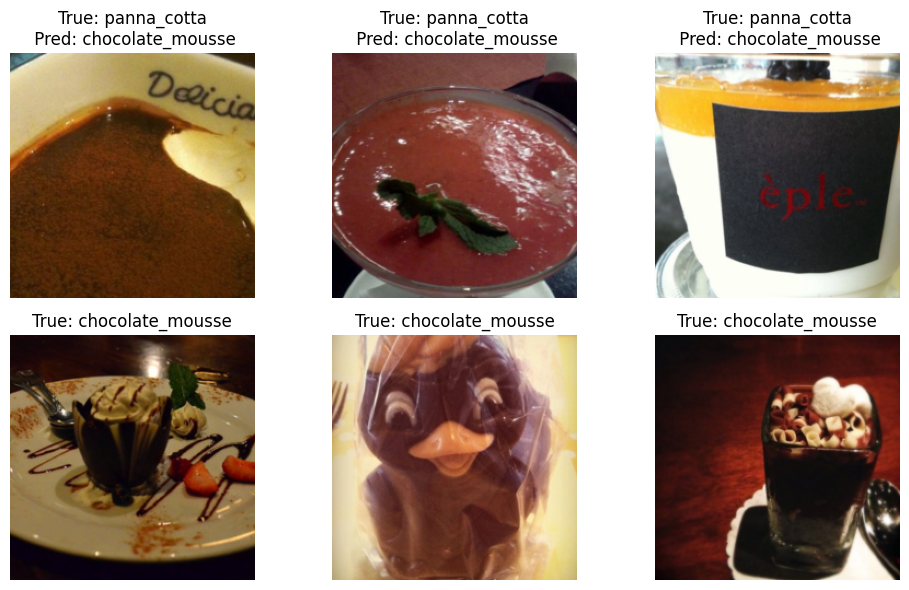

In [107]:
show_misclassified_images(test_loader,all_labels, all_preds, true_class=73, pred_class=22, n=3, idx_to_class=idx_to_class)

#### Fine tuning

In [23]:
for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

In [24]:
optimizer_ft = torch.optim.AdamW(
    [
        {"params": model.fc.parameters(), "lr": 1e-3},
        {"params": model.layer4.parameters(), "lr": 1e-4}
    ],
    weight_decay = 1e-4
)

In [25]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable:,} / {total:,}")

Trainable params: 15,171,685 / 23,714,981


In [28]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [34]:
best_val_acc = 0.0
patience = 3
patience_counter = 0

EPOCHS = 5
min_delta = 1e-3

for epoch in trange(EPOCHS, desc='Epochs', leave=True):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer_ft, criterion, device)

    val_loss, val_acc = validation_loop(model, val_loader, criterion, device)
    
    print(
        f'Epoch {epoch+1} / {EPOCHS} |'
        f'Train accuracy: {train_acc:.4f} |'
        f'Val accuracy: {val_acc:.4f} |'
        )
    
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_finetune.pt")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered") 
        break

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train:   0%|          | 0/2525 [00:00<?, ?it/s]

Epoch 1 / 5 |Train accuracy: 0.6457 |Val accuracy: 0.7362 |


Train:   0%|          | 0/2525 [00:00<?, ?it/s]

Epoch 2 / 5 |Train accuracy: 0.6974 |Val accuracy: 0.7509 |


Train:   0%|          | 0/2525 [00:00<?, ?it/s]

Epoch 3 / 5 |Train accuracy: 0.7285 |Val accuracy: 0.7621 |


Train:   0%|          | 0/2525 [00:00<?, ?it/s]

Epoch 4 / 5 |Train accuracy: 0.7476 |Val accuracy: 0.7678 |


Train:   0%|          | 0/2525 [00:00<?, ?it/s]

Epoch 5 / 5 |Train accuracy: 0.7639 |Val accuracy: 0.7764 |


In [19]:
model.load_state_dict(torch.load("best_model_finetune.pt", map_location=device))
model.to(device)
model.eval()

C:\Users\Ashraf\AppData\Local\Temp\ipykernel_22504\3939116402.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_finetune.pt", 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
test_acc = evaluate(model, test_loader, device)
print(f'Test accuracy: {test_acc:.4f}')

Test accuracy: 0.7746


In [23]:
pred_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        out = model(images)
        preds = out.argmax(dim = 1).cpu().numpy()

        pred_labels.append(preds)
        true_labels.append(labels.numpy())
pred_labels = np.concatenate(pred_labels)
true_labels = np.concatenate(true_labels)

In [24]:
conf_m = confusion_matrix(pred_labels, true_labels)

In [28]:
idx_to_class = {v:k for k,v in class_to_idx.items()}

In [37]:
cls_acc = conf_m.diagonal() / conf_m.sum(axis = 1)
order = np.argsort(cls_acc)
worst10 = order[:10]

print(f'Worst 10 per-class accuracy: ')
for idx in worst10:
    correct = conf_m[idx,idx]
    total = conf_m.sum(axis = 1)[idx]
    print(
        f"{idx:3d} |"
        f"{idx_to_class[idx]:20s} |"
        f"{correct:3d}/{total:3d} "
        f"(acc = {correct/total:.2f})"
    )

Worst 10 per-class accuracy: 
 93 |steak                | 56/132 (acc = 0.42)
  8 |bread_pudding        | 73/157 (acc = 0.46)
 77 |pork_chop            | 46/ 97 (acc = 0.47)
 22 |chocolate_mousse     | 51/ 93 (acc = 0.55)
 37 |filet_mignon         | 33/ 56 (acc = 0.59)
 47 |gnocchi              | 71/120 (acc = 0.59)
  0 |apple_pie            | 55/ 92 (acc = 0.60)
 67 |omelette             | 71/116 (acc = 0.61)
  1 |baby_back_ribs       | 86/139 (acc = 0.62)
 56 |huevos_rancheros     | 67/108 (acc = 0.62)


In [40]:
cls_acc = conf_m.diagonal() / conf_m.sum(axis = 1)
order = np.argsort(cls_acc)
best10 = order[-10:][::-1]

print(f'Best 10 per-class accuracy: ')
for idx in best10:
    correct = conf_m[idx,idx]
    total = conf_m.sum(axis = 1)[idx]
    print(
        f"{idx:3d} |"
        f"{idx_to_class[idx]:20s} |"
        f"{correct:3d}/{total:3d} "
        f"(acc = {correct/total:.2f})"
    )

Best 10 per-class accuracy: 
 33 |edamame              | 98/ 99 (acc = 0.99)
 63 |macarons             | 93/ 97 (acc = 0.96)
 69 |oysters              | 90/ 94 (acc = 0.96)
 51 |guacamole            | 82/ 87 (acc = 0.94)
  2 |baklava              | 77/ 82 (acc = 0.94)
 90 |spaghetti_bolognese  | 88/ 94 (acc = 0.94)
 27 |creme_brulee         | 84/ 90 (acc = 0.93)
 64 |miso_soup            | 93/100 (acc = 0.93)
 76 |pizza                | 77/ 83 (acc = 0.93)
 45 |frozen_yogurt        | 86/ 93 (acc = 0.92)


In [41]:
correct_top5 = 0
total = 0

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, top5 = outputs.topk(5, dim=1)

        correct_top5 += (top5 == labels.unsqueeze(1)).any(dim = 1).sum().item()
        total += labels.size(0)
top_5acc = correct_top5 / total
print(f'Top-5 Test Accuracy: {top_5acc}')

Top-5 Test Accuracy: 0.9321782178217822
